In [52]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
import seaborn as sns
%matplotlib inline

In [24]:
DF = pd.read_csv('shot_logs.csv')

In [25]:
print ('columns:', DF.shape[1], '\n')
print ('DF length:', len(DF), '\n')

print ('printing columns names and sample data:\n')

for i in DF.columns:
    print (i,DF[i][0],type(DF[i][0]))

('columns:', 21, '\n')
('DF length:', 128069, '\n')
printing columns names and sample data:

('GAME_ID', 21400899, <type 'numpy.int64'>)
('MATCHUP', 'MAR 04, 2015 - CHA @ BKN', <type 'str'>)
('LOCATION', 'A', <type 'str'>)
('W', 'W', <type 'str'>)
('FINAL_MARGIN', 24, <type 'numpy.int64'>)
('SHOT_NUMBER', 1, <type 'numpy.int64'>)
('PERIOD', 1, <type 'numpy.int64'>)
('GAME_CLOCK', '1:09', <type 'str'>)
('SHOT_CLOCK', 10.800000000000001, <type 'numpy.float64'>)
('DRIBBLES', 2, <type 'numpy.int64'>)
('TOUCH_TIME', 1.8999999999999999, <type 'numpy.float64'>)
('SHOT_DIST', 7.7000000000000002, <type 'numpy.float64'>)
('PTS_TYPE', 2, <type 'numpy.int64'>)
('SHOT_RESULT', 'made', <type 'str'>)
('CLOSEST_DEFENDER', 'Anderson, Alan', <type 'str'>)
('CLOSEST_DEFENDER_PLAYER_ID', 101187, <type 'numpy.int64'>)
('CLOSE_DEF_DIST', 1.3, <type 'numpy.float64'>)
('FGM', 1, <type 'numpy.int64'>)
('PTS', 2, <type 'numpy.int64'>)
('player_name', 'brian roberts', <type 'str'>)
('player_id', 203148, <type 'n

In [26]:
del DF['SHOT_RESULT']
del DF['W']

DF=DF[DF['TOUCH_TIME']>0]

In [27]:
def data_split(x):
    
    (a,b)=x.split('-')
    a=a.strip()
    
    return a

def home_team_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b1, b2) = b.split('@')
    if 'vs.' in b:
        (b2, b1) = b.split('vs.')

    b2 = b2.strip()

    return(b2)

def adversary_team_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b2, b1) = b.split('@')
    if 'vs.' in b:
        (b1, b2) = b.split('vs.')

    b2 = b2.strip()

    return(b2)

In [28]:
DF['date']=DF['MATCHUP'].apply(data_split)
DF['date']=DF['date'].apply(pd.to_datetime)
DF['home_team']=DF['MATCHUP'].apply(home_team_split)
DF['adv_team']=DF['MATCHUP'].apply(adversary_team_split)

In [29]:
list(DF.columns)

['GAME_ID',
 'MATCHUP',
 'LOCATION',
 'FINAL_MARGIN',
 'SHOT_NUMBER',
 'PERIOD',
 'GAME_CLOCK',
 'SHOT_CLOCK',
 'DRIBBLES',
 'TOUCH_TIME',
 'SHOT_DIST',
 'PTS_TYPE',
 'CLOSEST_DEFENDER',
 'CLOSEST_DEFENDER_PLAYER_ID',
 'CLOSE_DEF_DIST',
 'FGM',
 'PTS',
 'player_name',
 'player_id',
 'date',
 'home_team',
 'adv_team']

In [46]:
text_opts={'fontsize':16}

In [47]:
def count_shots(x):
    y=len(DF[DF['player_id']==x])
    return y

def count_shots_made(x):
    dummy_DF=DF[DF['FGM']==1]
    y=len(dummy_DF[dummy_DF['player_id']==x])
    return y

def count_games(x):
    y=(DF[DF['player_id']==x])
    z=len(y.groupby('GAME_ID'))
    return z

def max_attempts_in_game(x):
    y=DF[DF['player_id']==x]
    z=y.groupby('GAME_ID').count()
    k=np.max(z)[0]
    return k

players=pd.DataFrame(list(set(DF['player_id'])))
players.columns=['player_id']

players['total_attempts']=players['player_id'].apply(count_shots)
players['FGM']=players['player_id'].apply(count_shots_made)
players['ratio_FGM']=players['FGM']/players['total_attempts']
#confidence interval for each player- returns lower and upper
players['ratio_FGM_low'],players['ratio_FGM_upp']=sm.stats.proportion_confint(players['FGM'], players['total_attempts'])

players['ratio_FGM_low']=players['ratio_FGM']-players['ratio_FGM_low']
players['ratio_FGM_upp']=players['ratio_FGM_upp']-players['ratio_FGM']

players['total_games']=players['player_id'].apply(count_games)
players['avg_attempts_per_game']=players['total_attempts']/players['total_games']
players['avg_FGM_per_game']=players['FGM']/players['total_games']
players['max_attempts_in_game']=players['player_id'].apply(max_attempts_in_game)



print (len(players), 'different players')

players=players.sort_values('ratio_FGM')

(281, 'different players')


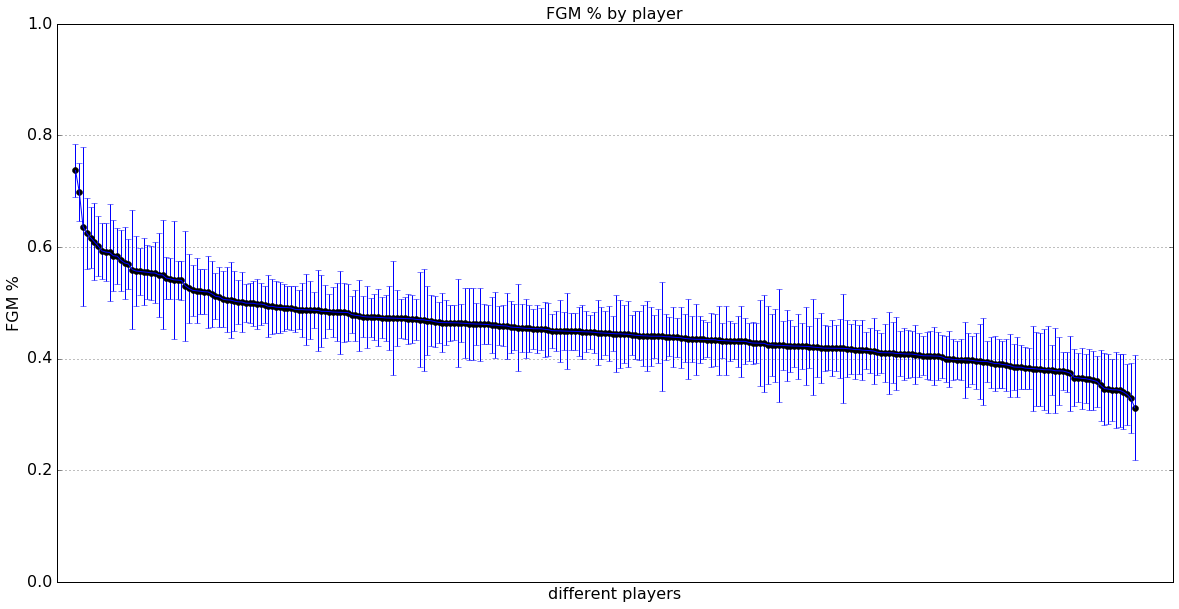

In [51]:
dummy=players.sort_values('ratio_FGM', ascending=False)

plt.figure(figsize=(20,10))

#plt.scatter(dummy.index,dummy.ratio_FGM.values)

plt.plot(dummy.ratio_FGM.values, 'ko', color='black')

plt.errorbar(np.arange(len(dummy)), dummy.ratio_FGM.values, yerr=[dummy['ratio_FGM_low'],dummy['ratio_FGM_upp']], ecolor='b')

plt.grid()
plt.xticks([], **text_opts)
plt.yticks(**text_opts)

plt.ylim(0,1)
plt.xlim(-5,290)

plt.title('FGM % by player', **text_opts)
plt.ylabel('FGM %', **text_opts)
plt.xlabel('different players', **text_opts)

In [40]:
set(DF[DF['player_id'].isin(players[players['ratio_FGM']>.65]['player_id'])].player_name)

{'deandre jordan', 'tyson chandler'}

In [45]:
set(DF[DF['player_id'].isin(players[players['ratio_FGM']<.32]['player_id'])].player_name)

{'mike miller'}

,GAME_ID,MATCHUP,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,date,home_team,adv_team
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,24,1,1,1:09,10.8,2,1.9,...,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,2015-03-04,BKN,CHA
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,24,2,1,0:14,3.4,0,0.8,...,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,2015-03-04,BKN,CHA
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,24,3,1,0:00,NaN,3,2.7,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,2015-03-04,BKN,CHA
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,24,4,2,11:47,10.3,2,1.9,...,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,2015-03-04,BKN,CHA
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,24,5,2,10:34,10.9,2,2.7,...,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,2015-03-04,BKN,CHA


In [63]:
new_DF = DF[['player_name','SHOT_DIST']]

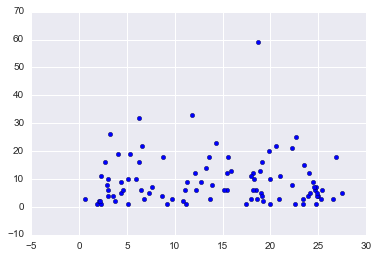

In [58]:
df_all = pd.read_csv("shot_logs.csv")
df = df_all.sample(frac =0.001)
list_players = ['Lebron James',  'Russell Westbrook', 'James Harden', 'Blake Griffin', 'Al Horford', 'Deandre Jordan', 'Stephen Curry', 'Chris Paul', 'Kyle Korver']
df_sum = df.groupby('player_name').sum()

df_mean  = df.groupby('player_name').mean()

plt.scatter(df_mean.SHOT_DIST, df_sum.SHOT_NUMBER)

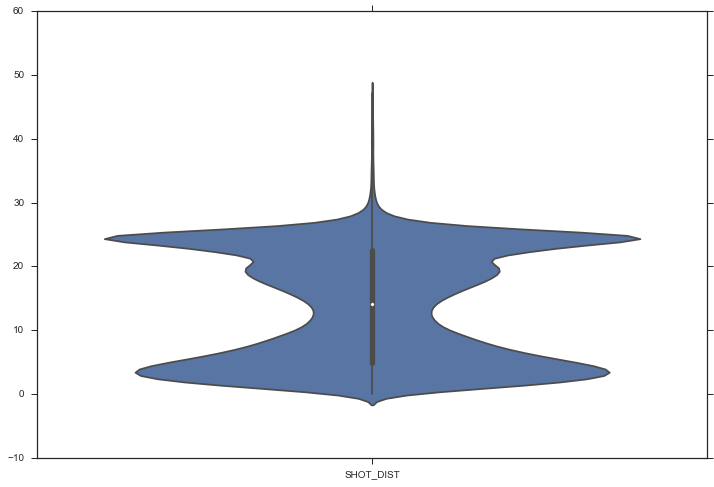

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)  
sns.violinplot(new_DF, scale='width')

In [85]:
curry_DF = new_DF[new_DF.player_name == 'stephen curry']

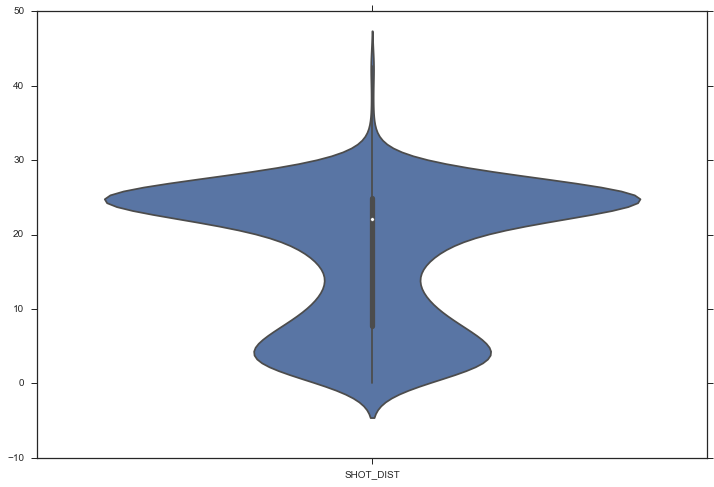

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)  
sns.violinplot(curry_DF, scale='width')

In [87]:
deandre_DF = new_DF[new_DF.player_name == 'deandre jordan']

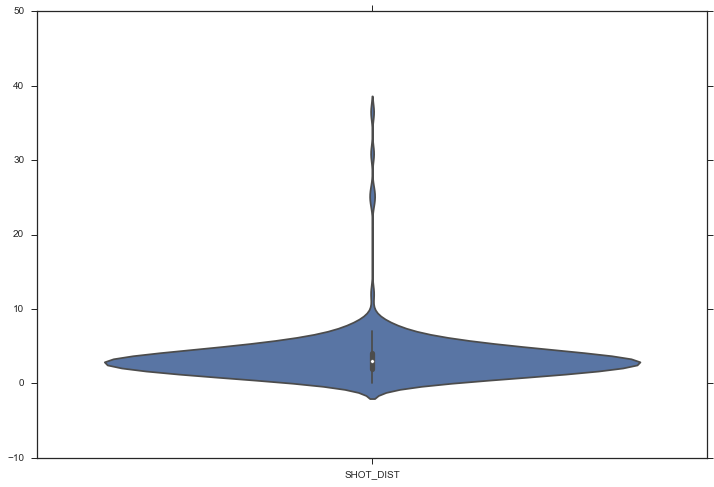

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)  
sns.violinplot(deandre_DF, scale='width')

In [89]:
miller_DF = new_DF[new_DF.player_name == 'mike miller']

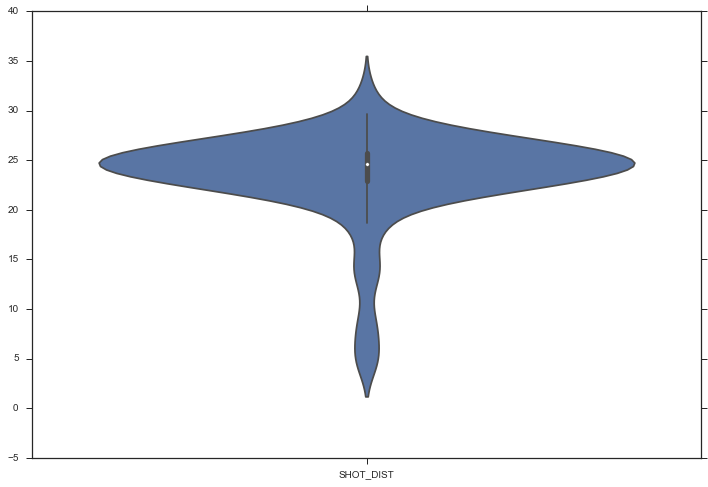

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)  
sns.violinplot(miller_DF, scale='width')

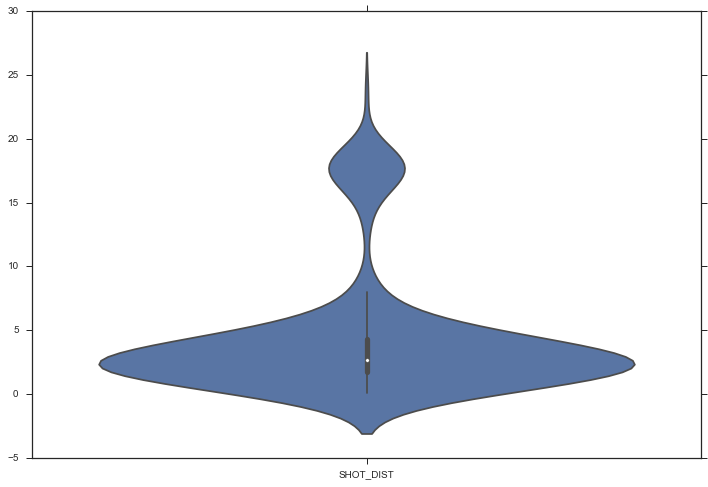

In [109]:
#tyson chandler
chandler_DF = new_DF[new_DF.player_name == 'tyson chandler']
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)  
sns.violinplot(chandler_DF, scale='width')

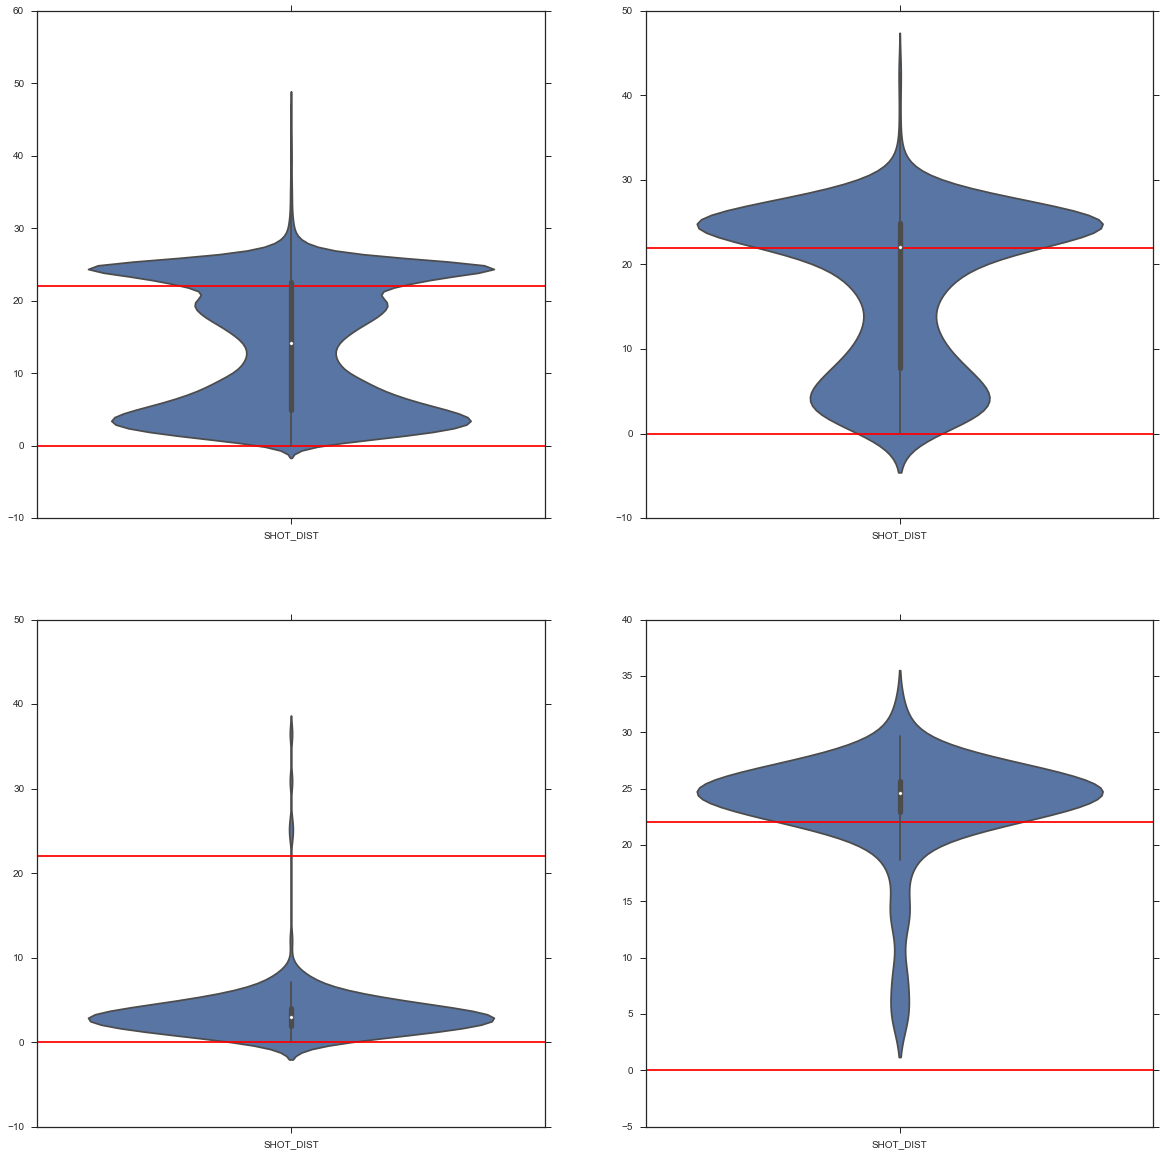

In [105]:
lst = [new_DF,curry_DF,deandre_DF,miller_DF]
fig = plt.figure(1,figsize=(20, 20))
for i, df in enumerate(lst):
    plt.subplot(2,2,i+1)
    plt.axhline(22,color='r')
    plt.axhline(0,color='r')
    sns.violinplot(df, scale='width')

In [107]:
new_DF.describe()

,SHOT_DIST
count,124711.000000
mean,13.745229
std,8.848028
min,0.000000
25%,4.900000
50%,14.100000
75%,22.600000
max,47.200000


In [110]:
DF.player_name.unique()

array(['brian roberts', 'bismack biyombo', 'al jefferson', 'cody zeller',
       'gary neal', 'gerald henderson', 'kemba walker',
       'michael kidd-gilchrist', 'lance stephenson', 'marvin williams',
       'jason maxiell', 'gordon hayward', 'trevor booker', 'enes kanter',
       'derrick favors', 'dante exum', 'jon ingles', 'trey burke',
       'rudy gobert', 'carlos boozer', 'jeremy lin', 'kobe bryant',
       'ed davis', 'ronnie price', 'wayne ellington', 'wesley johnson',
       'jordan hill', 'nick young', 'robert sacre', 'harrison barnes',
       'leandro barbosa', 'stephen curry', 'klay thompson',
       'marreese speights', 'shaun livingston', 'andrew bogut',
       'andre iguodala', 'draymond green', 'al horford', 'thabo sefolosha',
       'dennis schroder', 'paul millsap', 'kyle korver', 'pero antic',
       'kent bazemore', 'mike scott', 'jeff teague', 'demarre carroll',
       'marcin gortat', 'otto porter', 'kris humphries', 'bradley beal',
       'andre miller', 'garret

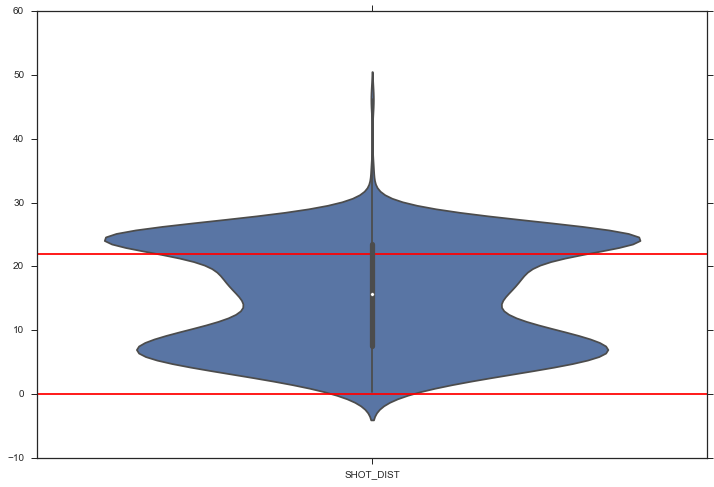

In [114]:
#average player
average_DF = new_DF[new_DF.player_name == 'joe johnson']
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.axhline(22,color='r')
plt.axhline(0,color='r')
sns.violinplot(average_DF, scale='width')